In [106]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
from math import *
from bandits import *
from scipy.special import ndtri
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline 

#### Bandit Setting

In [107]:
#As in Paper 1
#best mean arm = best var arm
#Arms = [(1, 5), (5, 5)]
#best mean arm != best var arm
# Arms = [(1, 1), (3, 15)]
#A
Arms = [(2, 1), (3, 1.5), (4, 5), (2, 2.5), (1, 1.5)]
#B
# Arms = [(1, 1), (3, 4), (5, 15), (7, 1), (9, 15)]
K = len(Arms)
bandit = gaussian_bandit(K, Arms)

#Parameters
#Number of rounds
n = 1000

trials = 10

In [108]:
def std_normal(y):
    return np.exp(-(y**2)/2.)/sqrt(2.*pi)

In [109]:
epsilon = 0.05 #quantile
alpha = 1. - epsilon

#Best arm
true_cvs = [arm[0] - sqrt(arm[1])*std_normal(ndtri(alpha))/(1.- alpha) for arm in Arms]
true_cvs = [arm[0] - sqrt(arm[1])*std_normal(ndtri(alpha))/(1.- alpha) for arm in Arms]
best_arm = np.argmax(true_cvs)
cv_best = true_cvs[best_arm]
true_cvs
best_arm

std_normal(ndtri(alpha))

[-0.0627128075074257,
 0.47370306785153415,
 -0.6123660556460431,
 -1.261435315261966,
 -1.5262969321484658]

1

0.10313564037537139

### UCB - Risk Neutral

In [93]:
#UCB

regret_trials_0 = []
cum_regret_trials_0 = []
perc_optimal_trials_0 = []
for trial in range(trials):

    #Sample means and variances
    sample_rewards = [[] for k in range(K)]
    sample_means = [0]*K
#     sample_vars = [0]*K
    net_rewards = []
    net_cv = 0
    #mean-variance values
    cvs = [0]*K
    #UCB values
    Bs = [0]*K
    #Number of times each arm is played
    num_played = [0]*K
    #Risk-averse regret
    regret_till_now = 0
    cum_regret_till_now = 0
    regret = []
    cum_regret = []
    perc_optimal = []

    for i in range(K):
        #Pull arm
        reward = bandit.pull_arm(i)
        #Add reward to list of rewards
        sample_rewards[i].append(reward)
        net_rewards.append(reward)
        #Update arm played count
        num_played[i] += 1  
        sample_means[i] = reward
        
        #Update CV
        cvs[i] = reward
        if i == 0:
            net_cv = reward
        else:   
            net_rewards.sort()
            net_cv = float(sum(net_rewards[:int(np.ceil(len(net_rewards)*epsilon))]\
                              ))/np.ceil(len(net_rewards)*epsilon)
        
        #Update regret
        regret_till_now = cv_best - net_cv
        cum_regret_till_now += cv_best - true_cvs[i]
        regret.append(regret_till_now)
        cum_regret.append(cum_regret_till_now)
        perc_optimal.append(num_played[best_arm]/float(i+1)) 

    for t in range(K+1, n+1):
        #Calculate  UCBs
        Bs = [mean + np.sqrt(8*np.log(t)/num) for mean, num in zip(sample_means, num_played)]

        #Pull best arm
        arm_to_pull = np.argmax(Bs)
        reward = bandit.pull_arm(arm_to_pull)
        sample_rewards[arm_to_pull].append(reward)
        net_rewards.append(reward)
        num_played[arm_to_pull] += 1

        #Update means
        sample_means[arm_to_pull] = np.mean(sample_rewards[arm_to_pull])
        sample_rewards[arm_to_pull].sort()
        net_rewards.sort()
        cvs[arm_to_pull] = float(sum(sample_rewards[arm_to_pull][:int(np.ceil(len(sample_rewards[arm_to_pull])*epsilon))]\
                          ))/np.ceil(len(sample_rewards[arm_to_pull])*epsilon)
        net_cv = float(sum(net_rewards[:int(np.ceil(len(net_rewards)*epsilon))]\
                          ))/np.ceil(len(net_rewards)*epsilon)
        #Update regret
        regret_till_now = cv_best - net_cv
        cum_regret_till_now += cv_best - true_cvs[arm_to_pull]
        regret.append(regret_till_now)
        cum_regret.append(cum_regret_till_now)
        perc_optimal.append(num_played[best_arm]/float(t)) 

    regret_trials_0.append(regret)
    cum_regret_trials_0.append(cum_regret)
    perc_optimal_trials_0.append(perc_optimal)

regret_avg_0 = np.mean(np.array(regret_trials_0), axis = 0)
cum_regret_avg_0 = np.mean(np.array(cum_regret_trials_0), axis = 0)
perc_optimal_avg_0 = np.mean(np.array(perc_optimal_trials_0), axis = 0)
print("Regret", regret_avg_0[-1])
print("Cumulative Regret", cum_regret_avg_0[-1])
print("Perc optimal", perc_optimal_avg_0[-1])
print(num_played)  #of the last trial
print(cvs)

('Regret', 1.1736470914553623)
('Cumulative Regret', 1049.3022361722383)
('Perc optimal', 0.0399)
[9, 60, 908, 14, 9]
[0.7164979355110688, 0.40872576397635, -0.83817172733385, -0.7352670491450013, -0.1847271905437562]


### MARAB

In [82]:
#refer paper
C = 2 # greater than 0

regret_trials_1 = []
perc_optimal_trials_1 = []
cum_regret_trials_1 = []
for trial in range(trials):
    
    #Sample means and variances
    sample_rewards = [[] for k in range(K)]
#     sample_means = [0]*K
#     sample_vars = [0]*K
    net_rewards = []
    net_cv = 0
    
    #cvar values
    cvs = [0]*K
    #indices
    Is = [0]*K
    #Number of times each arm is played
    num_played = [0]*K
    #Risk-averse regret
    regret_till_now = 0
    cum_regret_till_now = 0
    regret = []
    cum_regret = []
    perc_optimal = []
    #rounds count
    rounds = 0
    
    for i in range(K):
        #Pull arm
        reward = bandit.pull_arm(i)
        #Add reward to list of rewards
        sample_rewards[i].append(reward)
        net_rewards.append(reward)
        #Update arm played count
        num_played[i] += 1   
        
        #Update cvar
        cvs[i] = reward
        if i == 0:
            net_cv = reward
        else:   
            net_rewards.sort()
            net_cv = float(sum(net_rewards[:int(np.ceil(len(net_rewards)*epsilon))]\
                              ))/np.ceil(len(net_rewards)*epsilon)
        
        #Update regret
        regret_till_now = cv_best - net_cv
        cum_regret_till_now += cv_best - true_cvs[i]
        regret.append(regret_till_now)
        cum_regret.append(cum_regret_till_now)
        perc_optimal.append(num_played[best_arm]) 
        
    
    for i in range(K, n):
        #indices
        Is = [cv - sqrt(C*np.log(np.ceil(i*epsilon))/np.ceil(epsilon*num)) for cv, num in zip(cvs, num_played)]
        arm_to_pull = np.argmax(Is)
        
        reward = bandit.pull_arm(arm_to_pull)
        sample_rewards[arm_to_pull].append(reward)
        net_rewards.append(reward)
        num_played[arm_to_pull] += 1
        
        #Update cvar
        sample_rewards[arm_to_pull].sort()
        net_rewards.sort()
        cvs[arm_to_pull] = float(sum(sample_rewards[arm_to_pull][:int(np.ceil(len(sample_rewards[arm_to_pull])*epsilon))]\
                          ))/np.ceil(len(sample_rewards[arm_to_pull])*epsilon)
        net_cv = float(sum(net_rewards[:int(np.ceil(len(net_rewards)*epsilon))]\
                          ))/np.ceil(len(net_rewards)*epsilon)
        
        #Update regret
        regret_till_now = cv_best - net_cv
        cum_regret_till_now += cv_best - true_cvs[arm_to_pull]
        regret.append(regret_till_now)
        cum_regret.append(cum_regret_till_now)
        perc_optimal.append(num_played[best_arm]/float(i))
    
    regret_trials_1.append(regret)
    cum_regret_trials_1.append(cum_regret)
    perc_optimal_trials_1.append(perc_optimal)
    
regret_avg_1 = np.mean(np.array(regret_trials_1), axis = 0)
perc_optimal_avg_1 = np.mean(np.array(perc_optimal_trials_1), axis = 0)
cum_regret_avg_1 = np.mean(np.array(cum_regret_trials_1), axis = 0)
print("Regret", regret_avg_1[-1])
print("Cumulative Regret", cum_regret_avg_1[-1])
print("Perc optimal", perc_optimal_avg_1[-1])
print(num_played)  #of the last trial
print(cvs)

('Regret', 0.3837071864010945)
('Cumulative Regret', 400.10756643733714)
('Perc optimal', 0.5872872872872873)
[971, 5, 14, 5, 5]
[-0.07311800690199848, 0.1811367130371333, -0.3853111804970082, 0.029924700811717164, -0.6085954784414127]


### MARABOUT

In [83]:
def cvar_compute(rewards):
    n = len(rewards)
    cvar = rewards[int(np.ceil(n*epsilon)) - 1] + \
            sum([rewards[j] - rewards[int(np.ceil(n*epsilon)) - 1] \
             for j in range(int(np.floor(n*epsilon)))])/(n*epsilon)
        
    return cvar

In [100]:
#refer paper
C = 1 # greater than 2
beta = 0.5 # belongs to [0,1]

regret_trials_2 = []
perc_optimal_trials_2 = []
cum_regret_trials_2 = []
for trial in range(trials):
    
    #Sample means and variances
    sample_rewards = [[] for k in range(K)]
    net_rewards = []
    net_cv = 0
    
    #cvar values
    cvs = [0]*K
    #indices
    Is = [0]*K
    #Number of times each arm is played
    num_played = [0]*K
    #Risk-averse regret
    regret_till_now = 0
    cum_regret_till_now = 0
    regret = []
    cum_regret = []
    perc_optimal = []
    #rounds count
    rounds = 0
    
    for i in range(K):
        #Pull arm
        reward = bandit.pull_arm(i)
        #Add reward to list of rewards
        sample_rewards[i].append(reward)
        net_rewards.append(reward)
        #Update arm played count
        num_played[i] += 1   
        
        #Update cvar
        cvs[i] = reward
        if i == 0:
            net_cv = reward
        else:   
            net_rewards.sort()
            net_cv = cvar_compute(net_rewards)
        
        #Update regret        
        cum_regret_till_now += cv_best - true_cvs[i]
        regret_till_now = cv_best - net_cv
        regret.append(regret_till_now)
        cum_regret.append(cum_regret_till_now)
        perc_optimal.append(num_played[best_arm]) 
        
    
    for i in range(K, n):
        #indices
        Is = [cv + sqrt(11*(C*np.log(i) + beta*np.log(3))/(epsilon*num)) for cv, num in zip(cvs, num_played)]
        arm_to_pull = np.argmax(Is)
        
        reward = bandit.pull_arm(arm_to_pull)
        sample_rewards[arm_to_pull].append(reward)
        net_rewards.append(reward)
        num_played[arm_to_pull] += 1
        
        #Update cvar
        sample_rewards[arm_to_pull].sort()
        net_rewards.sort()
        cvs[arm_to_pull] = cvar_compute(sample_rewards[arm_to_pull])        
        net_cv = cvar_compute(net_rewards)
        
        #Update regret
        regret_till_now = cv_best - net_cv
        cum_regret_till_now += cv_best - true_cvs[arm_to_pull]        
        regret.append(regret_till_now)
        cum_regret.append(cum_regret_till_now)
        perc_optimal.append(num_played[best_arm]/float(i))
    
    regret_trials_2.append(regret)
    perc_optimal_trials_2.append(perc_optimal)
    cum_regret_trials_2.append(cum_regret)
    
regret_avg_2 = np.mean(np.array(regret_trials_2), axis = 0)
perc_optimal_avg_2 = np.mean(np.array(perc_optimal_trials_2), axis = 0)
cum_regret_avg_2 = np.mean(np.array(cum_regret_trials_2), axis = 0)
print("Regret", regret_avg_2[-1])
print("Cumulative Regret", cum_regret_avg_2[-1])
print("Perc optimal", perc_optimal_avg_2[-1])
print(num_played)  #of the last trial
print(cvs)

('Regret', 1.0936513905230694)
('Cumulative Regret', 727.3696794471945)
('Perc optimal', 0.37257257257257254)
[212, 457, 73, 130, 128]
[-0.2894417937263756, 0.6446966442889311, -2.3094466775386, -1.0195401328282014, -1.0494773861567372]


### cVaR-ETC (New)

In [103]:
tau = 15

regret_trials_3 = []
cum_regret_trials_3 = []
perc_optimal_trials_3 = []
for trial in range(trials):
    
    #Sample means and variances
    sample_rewards = [[] for k in range(K)]
    net_rewards = []
    net_cv = 0
    #mean-variance values
    cvs = [0]*K
    #Number of times each arm is played
    num_played = [0]*K
    #Risk-averse regret
    regret_till_now = 0
    cum_regret_till_now = 0
    regret = []
    cum_regret = []
    perc_optimal = []


    for i in range(K):
        for j in range(tau):
            #Pull arm
            reward = bandit.pull_arm(i)
            #Add reward to list of rewards
            sample_rewards[i].append(reward)
            net_rewards.append(reward)
            #Update arm played count
            num_played[i] += 1   
            
            #Update CV
            if j == 0:
                cvs[i] = reward
            else:
                sample_rewards[i].sort()
                cvs[i] = float(sum(sample_rewards[i][:int(np.ceil(len(sample_rewards[i])*epsilon))]\
                          ))/np.ceil(len(sample_rewards[i])*epsilon)
            if i == 0 and j == 0: 
                net_cv = reward
            else:
                net_rewards.sort()            
                net_cv = float(sum(net_rewards[:int(np.ceil(len(net_rewards)*epsilon))]\
                          ))/np.ceil(len(net_rewards)*epsilon)
            
            #Update regret
            regret_till_now = cv_best - net_cv
            cum_regret_till_now += cv_best - true_cvs[i]
            regret.append(regret_till_now)
            cum_regret.append(cum_regret_till_now)
            perc_optimal.append(num_played[best_arm]/float(i*tau+j+1)) 
            

    exploit_arm = np.argmax(cvs)
    for i in range(tau*K+1, n+1):
        reward = bandit.pull_arm(exploit_arm)
        sample_rewards[exploit_arm].append(reward)
        net_rewards.append(reward)
        num_played[exploit_arm] += 1
        #Update CV
        sample_rewards[exploit_arm].sort()
        net_rewards.sort()
        cvs[exploit_arm] = float(sum(sample_rewards[exploit_arm][:int(np.ceil(len(sample_rewards[exploit_arm])*epsilon))]\
                          ))/np.ceil(len(sample_rewards[exploit_arm])*epsilon)
        net_cv = float(sum(net_rewards[:int(np.ceil(len(net_rewards)*epsilon))]\
                          ))/np.ceil(len(net_rewards)*epsilon)
        
        #Update regret
        regret_till_now = cv_best - net_cv
        cum_regret_till_now += cv_best - true_cvs[exploit_arm]
        regret.append(regret_till_now)
        cum_regret.append(cum_regret_till_now)
        perc_optimal.append(num_played[best_arm]/float(i))

    regret_trials_3.append(regret)
    cum_regret_trials_3.append(cum_regret)
    perc_optimal_trials_3.append(perc_optimal)  

regret_avg_3 = np.mean(np.array(regret_trials_3), axis = 0)
cum_regret_avg_3 = np.mean(np.array(cum_regret_trials_3), axis = 0)
perc_optimal_avg_3 = np.mean(np.array(perc_optimal_trials_3), axis = 0)
print("Regret", regret_avg_3[-1])
print("Cumulative Regret", cum_regret_avg_3[-1])
print("Perc optimal", perc_optimal_avg_3[-1])
print(num_played)  #of the last trial
print(cvs)

('Regret', 0.6570885247632989)
('Cumulative Regret', 582.6713203471872)
('Perc optimal', 0.47750000000000004)
[15, 940, 15, 15, 15]
[-0.40184644117153967, 0.6793479236774999, 1.3747923040081491, -0.6862796315104638, -2.2830562414087097]


Text(0.5,0,'n')

Text(0,0.5,'regret')

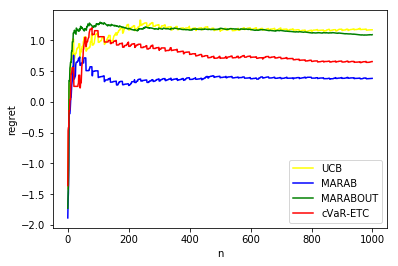

Text(0.5,0,'n')

Text(0,0.5,'perc of times optimal arm was played')

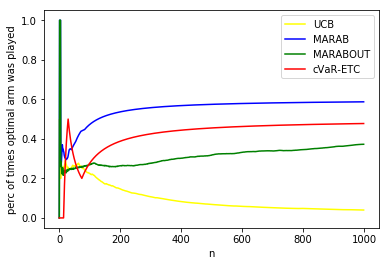

Text(0.5,0,'n')

Text(0,0.5,'cum regret')

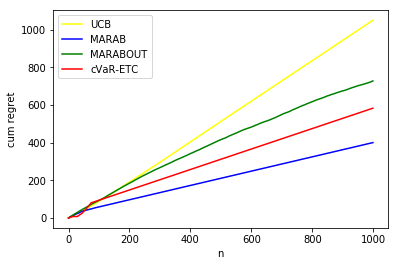

In [104]:
save = True
problem_id = "A"

#Plot regret vs rounds
plt.plot(regret_avg_0 , color = "yellow", label = "UCB")
plt.plot(regret_avg_1 , color = "blue", label = "MARAB")
plt.plot(regret_avg_2 , color = "green", label = "MARABOUT")
plt.plot(regret_avg_3 , color = "red", label = "cVaR-ETC")
plt.xlabel('n')
plt.ylabel('regret')
plt.legend()
if save == True:
    plt.savefig('cvar_' + problem_id + '_reg.png')
plt.show()

#Plot percentage optimal vs rounds
plt.plot(perc_optimal_avg_0 , color = "yellow", label = "UCB")
plt.plot(perc_optimal_avg_1 , color = "blue", label = "MARAB")
plt.plot(perc_optimal_avg_2 , color = "green", label = "MARABOUT")
plt.plot(perc_optimal_avg_3 , color = "red", label = "cVaR-ETC")
plt.xlabel('n')
plt.ylabel('perc of times optimal arm was played')
plt.legend()
if save == True:
    plt.savefig('cvar_' + problem_id + '_perc.png')
plt.show()

#Regret: shr
plt.plot(cum_regret_avg_0 , color = "yellow", label = "UCB")
plt.plot(cum_regret_avg_1, color = "blue", label = "MARAB")
plt.plot(cum_regret_avg_2, color = "green", label = "MARABOUT")
plt.plot(cum_regret_avg_3 , color = "red", label = "cVaR-ETC")
plt.xlabel('n')
plt.ylabel('cum regret')
plt.legend()
if save == True:
    plt.savefig('cvar_' + problem_id + '_cumreg.png')
plt.show()